In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext(appName = 'DicomTable')
sqlContext = SQLContext(sc)

In [2]:
from pyqae import PyqaeContext

In [3]:
from pydicom import read_file as dicom_simple_read
import numpy as np
from glob import glob
import pandas as pd

In [4]:
import os
from glob import glob
def local_read_depth(in_folder, depth, ext = '.dcm', inc_parent = False):
    """
    Read recursively from a list of directories
    :param in_folder: the base path to start from
    :param depth: the depth to look in the tree
    :param ext: the extension to search for
    :param inc_parent: to include the results from parent directories as well
    :return: a list of files
    """
    c_path = [in_folder]
    out_files = []
    for i in range(depth+1):
        c_wc_path = os.path.join(*(c_path + ['*']*i + ['*'+ext]))
        out_files += [] if (not inc_parent) and (i<depth) else glob(c_wc_path)
    return out_files

In [5]:
c_files = local_read_depth('../test/resources/', 1, inc_parent = False)

In [6]:
temp_dicom = dicom_simple_read(c_files[0])

In [7]:
for i, row in enumerate(temp_dicom):
    print(i, row)

0 (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
1 (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
2 (0008, 0012) Instance Creation Date              DA: '19890810'
3 (0008, 0013) Instance Creation Time              TM: '113816'
4 (0008, 0016) SOP Class UID                       UI: CT Image Storage
5 (0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6450.4012.824043186060994885795838106093
6 (0008, 0020) Study Date                          DA: '19890810'
7 (0008, 0021) Series Date                         DA: '19890810'
8 (0008, 0022) Acquisition Date                    DA: '19890810'
9 (0008, 0023) Content Date                        DA: '19890810'
10 (0008, 0030) Study Time                          TM: '113536'
11 (0008, 0031) Series Time                         TM: '113652'
12 (0008, 0032) Acquisition Time                    TM: '113713'
13 (0008, 0033) Content Time                        TM: '113816

In [8]:
from collections import namedtuple
from pyspark.sql.types import _infer_type, _has_nulltype, StructType, MapType, ArrayType
from pyspark.sql import Row
import pydicom as dicom
type_info = namedtuple('type_info', ['inferrable', 'realtype', 'has_nulltype', 'length', 'is_complex'])

def _tlen(x):
    """
    Try to calculate the length, otherwise return 1
    """
    try:
        return len(x)
    except:
        try:
            if np.isnan(x): return 0
        except:
            pass
        return 1

def _tnonempty(x):
    return _tlen(x)>0
def safe_type_infer(x):
    COMPLEX_TYPES = (StructType, MapType)
    try:
        sq_type = _infer_type(x)
        return type_info(True, sq_type, has_nulltype = _has_nulltype(sq_type), 
                         length = _tlen(x), is_complex = (type(sq_type) in COMPLEX_TYPES)
                        )
    except:
        return type_info(False, type(x), has_nulltype = False, 
                         length = _tlen(x), is_complex = False)

def _identify_column_types(in_df_dict):
    return dict([(k, safe_type_infer(v)) for (k, v) in in_df_dict.items()])

def _findvalidvalues(crow): 
        nz_vals = list(filter(_tnonempty, crow))
        return None if len(nz_vals)<1 else nz_vals[0]
def _countmissingvalues(crow): 
        nz_vals = list(filter(lambda i: not _tnonempty(i), crow))
        return len(nz_vals)
BAD_COLUMNS = tuple()

def dicom_to_dict(in_dicom, read_array = True):
    temp_dict = {a.name:a.value for a in in_dicom.iterall()}
    if in_dicom.__dict__.get('_pixel_array',None) is not None:
        temp_dict['Pixel Array'] = in_dicom.pixel_array.tolist()
    df_dicom = pd.DataFrame([temp_dict]) # just for the type conversion
    
    cur_kv_pairs = list(df_dicom.T.to_dict().values())[0] # first row
    valid_keys =_identify_column_types(cur_kv_pairs)
    do_keep = lambda key ,ti: ti.inferrable & (not ti.has_nulltype) & (not ti.is_complex)# & (ti.length>0)
    fvalid_keys = dict([ (k, do_keep(k,t_info)) for k, t_info in valid_keys.items()])
    return (dict([(k,v) for (k,v) in cur_kv_pairs.items() if fvalid_keys.get(k)]), 
            dict([(k,v) for (k,v) in cur_kv_pairs.items() if not fvalid_keys.get(k)]),
            valid_keys)

def dicoms_to_dict(dicom_list):
    fvr = lambda x: None if x.first_valid_index() is None else x[x.first_valid_index()]
    
    out_list = []
    
    for in_dicom in dicom_list:
        temp_dict = {a.name:a.value for a in in_dicom.iterall()}
        if in_dicom.__dict__.get('_pixel_array',None) is not None:
            temp_dict['Pixel Array'] = in_dicom.pixel_array.tolist()

        out_list += [temp_dict]
    df_dicom = pd.DataFrame(out_list) # just for the type conversion
    fvi_series = df_dicom.apply(_findvalidvalues, axis=0).to_dict()
    valid_keys = _identify_column_types(fvi_series)
    do_keep = lambda key, ti: ti.inferrable & (not ti.has_nulltype) # & (not ti.is_complex) & (ti.length>0)
    fvalid_keys = dict([ (k, do_keep(k,t_info)) for k, t_info in valid_keys.items()])
    good_columns = list(map(lambda x: x[0], filter(lambda x: x[1], fvalid_keys.items())))
    bad_columns = list(map(lambda x: x[0], filter(lambda x: not x[1], fvalid_keys.items())))
    sql_df = df_dicom[good_columns] 
    return sql_df.dropna(axis = 1)

def _remove_empty_columns(in_df):
    empty_cols = dict(filter(lambda kv: kv[1]>0, in_df.apply(_countmissingvalues,axis = 0).to_dict().items()))
    # remove missing columns
    return in_df[[ccol for ccol in in_df.columns if empty_cols.get(ccol,0)==0]]

# perform conversions
_dicom_conv_dict = {dicom.multival.MultiValue: lambda x: np.array(x).tolist(),
                   dicom.sequence.Sequence: lambda seq: [[(str(d_ele.tag), str(d_ele.value)) for d_ele in d_set] for d_set in seq]}

def _apply_conv_dict(in_ele):
    cnv_fcn = _dicom_conv_dict.get(type(in_ele[0]), None)
    if cnv_fcn is not None:
        return in_ele.map(cnv_fcn)
    else:
        return in_ele
def _conv_df(in_df):
    return in_df.apply(_apply_conv_dict)

def dicom_paths_to_df(in_path_list):
    f_df = dicoms_to_dict([dicom_simple_read(in_path, stop_before_pixels=True) for in_path in in_path_list])
    f_df['DICOMPath4Q'] = in_path_list
    rec_df = _remove_empty_columns(f_df)
    conv_df = _conv_df(rec_df)
    return conv_df

In [9]:
dicom_df = dicom_paths_to_df(c_files)
tdf = sqlContext.createDataFrame(dicom_df)
tdf.registerTempTable('DICOMSingleTable')
sqlContext.sql("""SELECT * FROM DICOMSingleTable LIMIT 1""").toPandas()

,Accession Number,Acquisition Date,Acquisition Number,Acquisition Time,Additional Patient History,Bits Allocated,Bits Stored,Body Part Examined,Code Meaning,Code Value,...,Specific Character Set,Study Date,Study Description,Study Instance UID,Study Time,Table Height,Window Center,Window Width,X-Ray Tube Current,DICOMPath4Q
0,7731341270494673,19890810,1,113713,F/U LUNG CA.,16,16,LUNG,Retain Safe Private Option,113111,...,ISO_IR 100,19890810,CT CHEST,(),113536,139.5,40.0,400.0,500,../test/resources/dicom/10-060.dcm


In [10]:
sqlContext.sql("""SELECT DICOMPath4Q, Modality FROM DICOMSingleTable LIMIT 1""").toPandas()

,DICOMPath4Q,Modality
0,../test/resources/dicom/10-060.dcm,CT


In [11]:
from pyspark.sql import functions as F
import pyspark.sql.types as sq_types
_sq_conv_map = {
    np.int16: sq_types.IntegerType,
    np.uint8: sq_types.IntegerType,
    np.float32: sq_types.FloatType,
    np.float64: sq_types.DoubleType
}

def _ndarray_to_sql(in_arr):
    """
    
    _ndarray_to_sql(np.zeros((3,3,3), np.float32))
    >>> ArrayType(ArrayType(ArrayType(FloatType,true),true),true)
    
    _ndarray_to_sql(np.zeros((3,3,3), np.int16))
    >>> ArrayType(ArrayType(ArrayType(IntegerType,true),true),true)
    
    _ndarray_to_sql(np.zeros((3,3,3), np.object))
    Exception: object is not supported in SparkSQL
    """
    assert type(in_arr) is np.ndarray, "Only works for NDArrays"
    for (dtype, stype) in _sq_conv_map.items():
        if dtype == in_arr.dtype:
            base_type = stype() # instantiate
            for c_dim in in_arr.shape:
                base_type = sq_types.ArrayType(base_type)
            return base_type
        
    raise Exception("{} is not supported in SparkSQL".format(in_arr.dtype))


twod_arr_type = sq_types.ArrayType(sq_types.ArrayType(sq_types.IntegerType()))
# the pull_input_tile function is wrapped into a udf to it can be applied to create the new image column
# numpy data is not directly supported and typed arrays must be used instead therefor we run the .tolist command
read_dicom_slice_udf = F.udf(lambda x: dicom_simple_read(x).pixel_array.tolist(), returnType = twod_arr_type)

In [12]:
t_img_df = tdf.withColumn("Pixel Array", read_dicom_slice_udf(tdf['DICOMPath4Q']))

In [13]:
from PIL import Image as PImage
from matplotlib.pyplot import cm
import base64
from io import BytesIO
def _np_to_uri(in_array, cmap = 'RdBu'):
    """
    
    _np_to_uri(np.zeros((100,100))
    >>> 'iVBORw0KGgoAAAANSUhEUgAAAIAAAACACAYAAADDPmHLAAABUElEQVR4nO3SQQEAEADAQBQRT/8ExPDYXYI9Ns/Yd5C1fgfwlwHiDBBngDgDxBkgzgBxBogzQJwB4gwQZ4A4A8QZIM4AcQaIM0CcAeIMEGeAOAPEGSDOAHEGiDNAnAHiDBBngDgDxBkgzgBxBogzQJwB4gwQZ4A4A8QZIM4AcQaIM0CcAeIMEGeAOAPEGSDOAHEGiDNAnAHiDBBngDgDxBkgzgBxBogzQJwB4gwQZ4A4A8QZIM4AcQaIM0CcAeIMEGeAOAPEGSDOAHEGiDNAnAHiDBBngDgDxBkgzgBxBogzQJwB4gwQZ4A4A8QZIM4AcQaIM0CcAeIMEGeAOAPEGSDOAHEGiDNAnAHiDBBngDgDxBkgzgBxBogzQJwB4gwQZ4A4A8QZIM4AcQaIM0CcAeIMEGeAOAPEGSDOAHEGiDNAnAHiDBBngDgDxBkgzgBxDxypAoX8C2RlAAAAAElFTkSuQmCC'
    """
    test_img_data = np.array(in_array).astype(np.float32)
    test_img_data -= test_img_data.mean()
    test_img_data /= test_img_data.std()
    test_img_color = cm.bone((test_img_data+0.5).clip(0,1))
    p_data = PImage.fromarray((test_img_color*255).clip(0,255).astype(np.uint8))
    rs_p_data = p_data.resize((128, 128), resample = PImage.BICUBIC)
    out_img_data = BytesIO()
    rs_p_data.save(out_img_data, format = 'png')
    out_img_data.seek(0)
    return base64.b64encode(out_img_data.read()).decode("ascii").replace("\n", "")
image_to_uri_udf = F.udf(_np_to_uri, returnType = sq_types.StringType())

In [14]:
t_prev_df = t_img_df.withColumn("Preview4Q", image_to_uri_udf(t_img_df['Pixel Array']))

In [15]:
_wrap_uri = lambda data_uri: "data:image/png;base64,{0}".format(data_uri)
def display_uri(uri_list):
    """
    
    show_uri(_np_to_uri(np.zeros((100,100))))
    
    """
    from IPython.display import HTML
    out_html = ""
    for in_uri in uri_list:
        out_html += """<img src="{0}" width = "100px" height = "100px" />""".format(_wrap_uri(in_uri))
    return HTML(out_html)

In [16]:
test_ds = t_prev_df.take(1)

NameError: name 'n_rows' is not defined


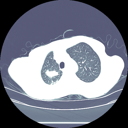

In [20]:
display_uri([test_ds[0]['Preview4Q']])

In [22]:
def _fix_col_names(t_prev_df):
    new_df = t_prev_df
    for col in t_prev_df.columns:
        new_col = col
        for fix_chr in ' ,;{}()\n\t=':
            new_col = "".join(new_col.split(fix_chr))
        new_df = new_df.withColumnRenamed(col, new_col)
    return new_df

new_df = _fix_col_names(t_prev_df)

Py4JJavaError: An error occurred while calling o263.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:224)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:154)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:654)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:654)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:654)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:273)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:267)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:225)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:547)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 12.0 failed 1 times, most recent failure: Lost task 0.0 in stage 12.0 (TID 96, localhost, executor driver): org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:285)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:197)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:196)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.parquet.schema.InvalidSchemaException: Cannot write a schema with an empty group: optional group FrameofReferenceUID {
}
	at org.apache.parquet.schema.TypeUtil$1.visit(TypeUtil.java:27)
	at org.apache.parquet.schema.GroupType.accept(GroupType.java:229)
	at org.apache.parquet.schema.TypeUtil$1.visit(TypeUtil.java:31)
	at org.apache.parquet.schema.TypeUtil$1.visit(TypeUtil.java:37)
	at org.apache.parquet.schema.MessageType.accept(MessageType.java:58)
	at org.apache.parquet.schema.TypeUtil.checkValidWriteSchema(TypeUtil.java:23)
	at org.apache.parquet.hadoop.ParquetFileWriter.<init>(ParquetFileWriter.java:225)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:342)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:302)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:37)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:151)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$SingleDirectoryWriteTask.newOutputWriter(FileFormatWriter.scala:367)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$SingleDirectoryWriteTask.execute(FileFormatWriter.scala:378)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:269)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:267)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1411)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:272)
	... 8 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:194)
	... 31 more
Caused by: org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:285)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:197)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:196)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.parquet.schema.InvalidSchemaException: Cannot write a schema with an empty group: optional group FrameofReferenceUID {
}
	at org.apache.parquet.schema.TypeUtil$1.visit(TypeUtil.java:27)
	at org.apache.parquet.schema.GroupType.accept(GroupType.java:229)
	at org.apache.parquet.schema.TypeUtil$1.visit(TypeUtil.java:31)
	at org.apache.parquet.schema.TypeUtil$1.visit(TypeUtil.java:37)
	at org.apache.parquet.schema.MessageType.accept(MessageType.java:58)
	at org.apache.parquet.schema.TypeUtil.checkValidWriteSchema(TypeUtil.java:23)
	at org.apache.parquet.hadoop.ParquetFileWriter.<init>(ParquetFileWriter.java:225)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:342)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:302)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:37)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:151)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$SingleDirectoryWriteTask.newOutputWriter(FileFormatWriter.scala:367)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$SingleDirectoryWriteTask.execute(FileFormatWriter.scala:378)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:269)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:267)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1411)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:272)
	... 8 more


In [23]:
new_df.write.json("dicom_data_json")

In [24]:
new_df.registerTempTable("NewTable")

In [25]:
n_qry = sqlContext.sql("""
SELECT Preview4Q FROM NewTable LIMIT 5
""")
n_qry.explain()

== Physical Plan ==
CollectLimit 5
+- *(2) LocalLimit 5
   +- *(2) Project [pythonUDF0#14275 AS Preview4Q#14023]
      +- BatchEvalPython [_np_to_uri(<lambda>(DICOMPath4Q#79))], [DICOMPath4Q#79, pythonUDF0#14275]
         +- *(1) Project [DICOMPath4Q#79]
            +- Scan ExistingRDD[Accession Number#0,Acquisition Date#1,Acquisition Number#2L,Acquisition Time#3,Additional Patient History#4,Bits Allocated#5L,Bits Stored#6L,Body Part Examined#7,Code Meaning#8,Code Value#9,Coding Scheme Designator#10,Columns#11L,Content Date#12,Content Time#13,Convolution Kernel#14,Data Collection Diameter#15,De-identification Method#16,De-identification Method Code Sequence#17,Distance Source to Detector#18,Distance Source to Patient#19,Exposure#20L,Exposure Time#21L,Filter Type#22,Focal Spot(s)#23,... 56 more fields]



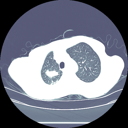

In [26]:
display_uri(n_qry.toPandas()['Preview4Q'])

# Basic DICOM Tags

In [29]:
good_dict, bad_dict, vkeys = dicom_to_dict(temp_dicom)
#bad_dict.values()
print(bad_dict.keys())

dict_keys(['De-identification Method Code Sequence', 'Frame of Reference UID', 'Image Orientation (Patient)', 'Image Position (Patient)', 'Image Type', "Patient's Name", 'Pixel Data', 'Pixel Spacing', 'Private tag data', 'Procedure Code Sequence', "Referring Physician's Name", 'SOP Class UID', 'SOP Instance UID', 'Series Instance UID', 'Study Instance UID', '[Angle of first view]', '[Biopsy T location]', '[Biopsy position]', '[Biopsy ref location]', '[Cell number at Theta]', '[Cell spacing]', '[Center A coord of plane image]', '[Center R coord of plane image]', '[Center S coord of plane image]', '[Corrected after glow terms]', '[DAS ad input]', '[DAS cal mode]', '[DAS fpa gain]', '[DAS gain]', '[DAS output source]', '[DAS trigger source]', '[DAS type]', '[Degree of rotation]', '[Delta Start Time [msec]]', '[Dependent on #views processed]', '[Detector Channel]', '[Duration of X-ray on]', '[First scan ras]', '[Horiz. Frame of ref.]', '[Image Filter]', '[Image from which prescribed]', '[I

In [31]:
print('Complex Field', vkeys['Frame of Reference UID'])

Complex Field type_info(inferrable=True, realtype=StructType(List()), has_nulltype=False, length=64, is_complex=True)


In [32]:
full_dicom_list = dicoms_to_dict([dicom_simple_read(in_path, stop_before_pixels=True) for in_path in c_files])